In [3]:
%%capture --no-stderr
%pip install -U --quiet langchain_ollama

In [1]:
import os
from langchain.document_loaders import DirectoryLoader, BSHTMLLoader
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
from rank_bm25 import BM25Okapi


# Define the directory containing HTML files
docs_directory = fr"C:\Users\gi0136\Desktop\geoserver-2.26.2"

# Load HTML files using DirectoryLoader with BSHTMLLoader
loader = DirectoryLoader(docs_directory, glob='**/*.html', loader_cls=BSHTMLLoader)
documents = loader.load()


# Split documents into smaller chunks for better retrieval
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
document_chunks = text_splitter.split_documents(documents)
chroma_db_path = os.path.join(os.getcwd(), "chroma_db")

bm25_corpus = [doc.page_content for doc in document_chunks]
tokenized_corpus = [doc.split() for doc in bm25_corpus]
bm25_index = BM25Okapi(tokenized_corpus)

# Initialize Chroma vector store with Ollama embeddings
embedding_function = OllamaEmbeddings(model='llama3.1:8b',base_url='localhost:11434')  # Ensure you have an API key configured
vector_store = Chroma.from_documents(document_chunks,collection_name="html_vector",embedding=embedding_function,persist_directory=chroma_db_path)

# Save vector database for later use
vector_store.persist()
retriever = vector_store.as_retriever()

print("GeoServer User Manual HTML files loaded into ChromaDB.")


GeoServer User Manual HTML files loaded into ChromaDB.


C:\Users\gi0136\AppData\Local\Temp\ipykernel_25604\3388011656.py:32: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vector_store.persist()


In [2]:
from operator import itemgetter

def hybrid_search(query, k=5):
    """Perform hybrid search using BM25 and ChromaDB."""
    
    # BM25 Search
    tokenized_query = query.split()
    bm25_scores = bm25_index.get_scores(tokenized_query)
    
    # Get top BM25 results
    bm25_top_idxs = sorted(range(len(bm25_scores)), key=lambda i: bm25_scores[i], reverse=True)[:k]
    bm25_results = [(bm25_corpus[i], bm25_scores[i]) for i in bm25_top_idxs]

    # Vector Search
    vector_results = vector_store.similarity_search_with_score(query, k=k)
    
    # Merge BM25 & Vector results
    hybrid_results = []
    
    for doc, score in vector_results:
        hybrid_results.append((doc.page_content, score))  # Vector scores are similarity-based (lower is better)
    
    hybrid_results.extend(bm25_results)  # Add BM25 results
    
    # Normalize and Re-rank by combined score
    hybrid_results = sorted(hybrid_results, key=itemgetter(1), reverse=True)[:k]

    return "\n".join([res[0] for res in hybrid_results])


In [3]:
from langchain_ollama import OllamaLLM
from langchain.llms.ollama import Ollama
from langchain.agents import initialize_agent, Tool
from langchain_community.tools.vectorstore.tool import VectorStoreQATool
import os
os.environ['OPENAI_API_KEY']=''

def query_vector_store(query: str, k: int = 5):
    docs = vector_store.similarity_search(query, k=k)
    return "\n".join([doc.page_content for doc in docs])

# Initialize LLM
llm = OllamaLLM(model="llama3.1:8b")


def query_geoserver_manual(prompt: str):
    context = hybrid_search(prompt)
    print(f'context from vector store:{context}')
    full_prompt = f"Based on the following GeoServer documentation, answer the query:\n\n{context}\n\nQuery: {prompt}"
    response = llm.invoke(full_prompt)
    return response

# Example usage
if __name__ == "__main__":
    user_query = "how to create a wps request?"
    answer = query_geoserver_manual(user_query)
    print("Answer:", answer)


context from vector store:The result produced is a zipped file to download.


Asynchronous execution¶
The process can also be performed asynchronously.
In this case, the second part (wps:ResponseForm) of the wps download payload slightly changes, by using the storeExecuteResponse and status parameters, set to true for the <wps:ResponseDocument>:

<wps:ResponseForm>
  <wps:ResponseDocument storeExecuteResponse="true" status="true">
    <wps:RawDataOutput mimeType="application/zip">
      <ows:Identifier>result</ows:Identifier>
    </wps:RawDataOutput>
  </wps:ResponseDocument>>
</wps:ResponseForm>



In case of asynchronous execution, the initial request to download data returns an xml indication that the process has successfully started:
The resultant description will look like this:



Figure 23: A custom description¶


It is also possible to create one description template for all featureTypes in a given namespace. To do this, create a description.ftl file as above, and save it as <d

In [3]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_doc",
    "Search and return information about getting an individual coverage from geoserver.",
)

tools = [retriever_tool]


In [4]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [5]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_ollama import ChatOllama

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOllama(temperature=0, model_name="llama3.1:8b", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOllama(temperature=0, streaming=True, model="llama3.1:8b")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOllama(temperature=0, model="llama3.1:8b", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOllama(model="llama3.1:8b", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************


c:\Users\gi0136\AppData\Local\miniconda3\envs\agent\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [6]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

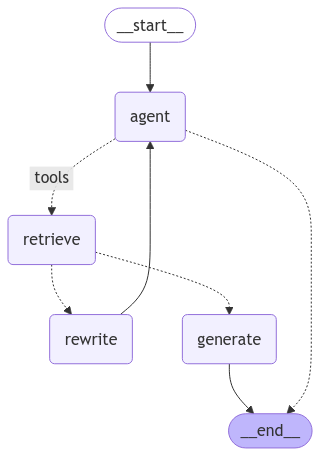

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
import pprint

inputs = {
    "messages": [
        ("user", "What are the parameters required to get a coverage?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-02-12T11:04:01.780240472Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6296435765, 'load_duration': 5595911010, 'prompt_eval_count': 178, 'prompt_eval_duration': 322000000, 'eval_count': 17, 'eval_duration': 375000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-6037c3ab-0a79-4884-949b-4d08d672eba5-0', tool_calls=[{'name': 'retrieve_doc', 'args': {'query': 'coverage'}, 'id': '1c0da3ad-c9a0-4109-b4cd-1fd495f71458', 'type': 'tool_call'}], usage_metadata={'input_tokens': 178, 'output_tokens': 17, 'total_tokens': 195})]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Example data\nContent-Type: application/json\n\n"@class": "projected"\n        },\n        "nativeFormat": "Ge

c:\Users\gi0136\AppData\Local\miniconda3\envs\agent\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ValidationError: 1 validation error for ChatOllama
model
  Field required [type=missing, input_value={'model_name': 'llama3.1:...': 0, 'streaming': True}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

In [16]:
import requests
import xml.etree.ElementTree as ET

def get_layer_capabilities(workspace, layer_name):
    """Fetches the capabilities document for a GeoServer layer and extracts relevant details for visualization."""
    
    base_url = "http://13.202.93.120:8080/geoserver"
    capabilities_url = f"{base_url}/{workspace}/wms?SERVICE=WMS&REQUEST=GetCapabilities"
    namespace = {"wms": "http://www.opengis.net/wms"}
    layer_tag = ".//wms:Layer"
    identifier_tag = "wms:Name"
    bbox_tag =  "LatLonBoundingBox"
    srs_tag = "wms:SRS"

    try:
        response = requests.get(capabilities_url)
        response.raise_for_status()
        xml_content = response.text

        # Parse XML
        root = ET.fromstring(xml_content)
        layer_info = {}

        # Find the layer
        for layer in root.findall(".//wms:Layer", namespace):
            name = layer.find("wms:Name", namespace)
            if name is not None and name.text == layer_name:
                layer_info["name"] = name.text
                layer_info["title"] = layer.find("wms:Title", namespace).text if layer.find("wms:Title", namespace) is not None else layer_name
                
                # Extract Bounding Box
                bbox = layer.find("wms:LatLonBoundingBox", namespace)
                if bbox is not None:
                    layer_info["bounds"] = {
                        "min_lon": float(bbox.attrib["minx"]),
                        "min_lat": float(bbox.attrib["miny"]),
                        "max_lon": float(bbox.attrib["maxx"]),
                        "max_lat": float(bbox.attrib["maxy"])
                    }
                else:
                    layer_info["bounds"] = "Bounding box not found"

                # Extract EPSG Code
                srs = layer.find("wms:SRS", namespace)
                layer_info["epsg"] = srs.text.replace("EPSG:", "") if srs is not None else "Unknown EPSG"

                # Extract Styles
                styles = []
                for style in layer.findall("wms:Style", namespace):
                    style_name = style.find("wms:Name", namespace)
                    if style_name is not None:
                        styles.append(style_name.text)
                layer_info["styles"] = styles

                # Extract Legend URL (if available)
                legend_url = layer.find(".//wms:LegendURL/wms:OnlineResource", namespace)
                if legend_url is not None:
                    layer_info["legend_url"] = legend_url.attrib.get("{http://www.w3.org/1999/xlink}href", "")

                break  # Exit loop after finding the correct layer

        return layer_info if layer_info else {"error": "Layer not found in capabilities document"}

    except requests.exceptions.RequestException as e:
        return {"error": f"Failed to fetch capabilities: {str(e)}"}
    except ET.ParseError:
        return {"error": "Failed to parse capabilities XML"}

get_layer_capabilities('Umshing', 'Village')

{'name': 'Village',
 'title': 'Village',
 'bounds': 'Bounding box not found',
 'epsg': 'Unknown EPSG',
 'styles': ['polygon'],
 'legend_url': 'http://13.202.93.120:8080/geoserver/Umshing/ows?service=WMS&version=1.3.0&request=GetLegendGraphic&format=image%2Fpng&width=20&height=20&layer=Village'}